# Obama Or Trump (Binary classification with Multi Layer Perceptrons)

The purpose of this notebook to introduce the basic conception of binary classification with the Multi Layer Perceptron (or Feed Forward Neural Networks) (MLP in the further part).
We will collect tweets from Twitter both from Obama and Trump and we train a neural network which try to decide each tweet whom belongs to.

## Data collection
Usually if we want to train a Neural networks, we need a huge amount of data. In this case, we will collect data from twitter with the official Twitter Python Api.

Before we want to use, we have to register our project in the twitter homepage, and the developer shall read the terms of use.

The documentation can be found:
http://www.tweepy.org/

In [1]:
import os
import json

twitter_accounts = {"Trump" : "@realDonaldTrump", "Obama": "@BarackObama"}

if os.path.exists("data/tweets.txt"):
    tweets = json.load(open("data/tweets.txt"))
else:
    import tweepy
    from tweepy import OAuthHandler
    from config import consumer_key, consumer_secret, access_token, access_secret
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    tweets = {}
    for key, value in twitter_accounts.items():
        tweets[key] = [status._json for status in tweepy.Cursor(api.user_timeline, screen_name=value, tweet_mode="extended").items()]
        
    #save the collected tweets
    os.makedirs("data", exist_ok=True)
    with open("data/tweets.txt", "w") as f:
        json.dump(tweets, f)

In [2]:
for key, value in twitter_accounts.items():
    print("We collected {} tweets form {}".format(len(tweets[key]), key))

We collected 3227 tweets form Trump
We collected 3216 tweets form Obama


We got the tweets, each tweets are a dictionary, which contains the text, the number of shares, the time of publish, and location. So, we have a lot of data, we should do some data exploration, just for the curiosity.

## Data exploration.

Just check some tweets

In [3]:
for author in twitter_accounts.keys():
    for index in [0, 1000, 2000, -1]:
        print("{}: {}\n".format(author, tweets[author][index]["full_text"]))

Trump: How the hell is Bruce Ohr still employed at the Justice Department? Disgraceful!  Witch Hunt!

Trump: Farmers have not been doing well for 15 years. Mexico, Canada, China and others have treated them unfairly. By the time I finish trade talks, that will change. Big trade barriers against U.S. farmers, and other businesses, will finally be broken. Massive trade deficits no longer!

Trump: “House votes on controversial FISA ACT today.” This is the act that may have been used, with the help of the discredited and phony Dossier, to so badly surveil and abuse the Trump Campaign by the previous administration and others?

Trump: RT @FoxNews: .@POTUS: "Our infrastructure will again be the best in the world. We used to have the greatest infrastructure anywhere in the…

Obama: Congratulations to Hawaii for winning the Little League World Series! You make America very proud. 🤙🏾 https://t.co/8Un7LPXgX1

Obama: "The American auto industry is all the way back." —President Obama #MadeInAmeric

Now we can just check, when the most tweets were created, and check the most used words, and checked the most retweeted and liked tweets.

For dates, we can check by date, by the day of the week, of by the period of the day.
I will use the following perioud of the day:
+ DAWN if the tweet created between 04 - 08 
+ MORNING if the tweet created between 08 - 12 
+ AFTERNOON if the tweet created between 12 - 18
+ EVENING if the tweet created between 18 - 22
+ NIGHT if the tweet created between 22 - 04

In [4]:
import re
from collections import Counter

def get_date_from_tweet(date_str):
    date = date_str.split()
    return " ".join([date[-1], date[1], date[2]])

dates = {}
texts = {}
days = {}
section_of_days = {}

for author in twitter_accounts.keys():
    days[author] = Counter([tweet["created_at"][:3] for tweet in tweets[author]])
    dates[author] = Counter([get_date_from_tweet(tweet["created_at"]) for tweet in tweets[author]])
    texts[author] = [tweet["full_text"] for tweet in tweets[author]]
    section_of_day = []
    for tweet in tweets[author]:
        time = re.findall("\d{2}:\d{2}:\d{2}", tweet["created_at"])[0]
        hours = int(time[:2])
        if hours < 4 or hours >= 22:
            section_of_day.append("night")
        elif hours < 8:
            section_of_day.append("dawn")
        elif hours < 12:
            section_of_day.append("morning")
        elif hours < 18:
            section_of_day.append("afternoon")
        elif hours < 22:
            section_of_day.append("evening")
    section_of_days[author] = Counter(section_of_day)  

Check the most retweeted and most liked tweets


In [5]:
from operator import itemgetter
for author in twitter_accounts.keys():
    new_list = sorted(tweets[author], key=itemgetter("retweet_count"), reverse=True)
    for tweet in new_list[:3]:
        print('""{}" tweet from {} got {} retweet\n'.format(tweet["full_text"], author, tweet["retweet_count"]))

""Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen!" tweet from Trump got 256546 retweet

""North Korean Leader Kim Jong Un just stated that the “Nuclear Button is on his desk at all times.” Will someone from his depleted and food starved regime please inform him that I too have a Nuclear Button, but it is a much bigger &amp; more powerful one than his, and my Button works!" tweet from Trump got 181929 retweet

""RT @realDonaldTrump: They just didn't get it, but they do now! https://t.co/9T50NupkDy" tweet from Trump got 110294 retweet

"""No one is born hating another person because of the color of his skin or his background or his religion..." https://t.co/InZ58zkoAm" tweet from Obama got 1683183 retweet

""ME:  Joe, about halfway through the speech, I’m gonna wish you a happy birth--
BIDEN:  IT’S MY BIRTHDAY!
ME:  Joe.
 
Happy birthday to @JoeBiden, my brother

In [6]:
for author in twitter_accounts.keys():
    new_list = sorted(tweets[author], key=itemgetter("favorite_count"), reverse=True)
    for tweet in new_list[:3]:
        print('""{}" tweet from {} got {} likes\n'.format(tweet["full_text"], author, tweet["favorite_count"]))

""Why would Kim Jong-un insult me by calling me "old," when I would NEVER call him "short and fat?" Oh well, I try so hard to be his friend - and maybe someday that will happen!" tweet from Trump got 598389 likes

""North Korean Leader Kim Jong Un just stated that the “Nuclear Button is on his desk at all times.” Will someone from his depleted and food starved regime please inform him that I too have a Nuclear Button, but it is a much bigger &amp; more powerful one than his, and my Button works!" tweet from Trump got 484042 likes

""Thank you Kanye, very cool! https://t.co/vRIC87M21X" tweet from Trump got 356635 likes

"""No one is born hating another person because of the color of his skin or his background or his religion..." https://t.co/InZ58zkoAm" tweet from Obama got 4544498 likes

""John McCain is an American hero &amp; one of the bravest fighters I've ever known. Cancer doesn't know what it's up against. Give it hell, John." tweet from Obama got 2060891 likes

""ME:  Joe, about

Okay, we have all the data, just do some nice visualization

In [7]:
import numpy as np
import matplotlib.pyplot as plt

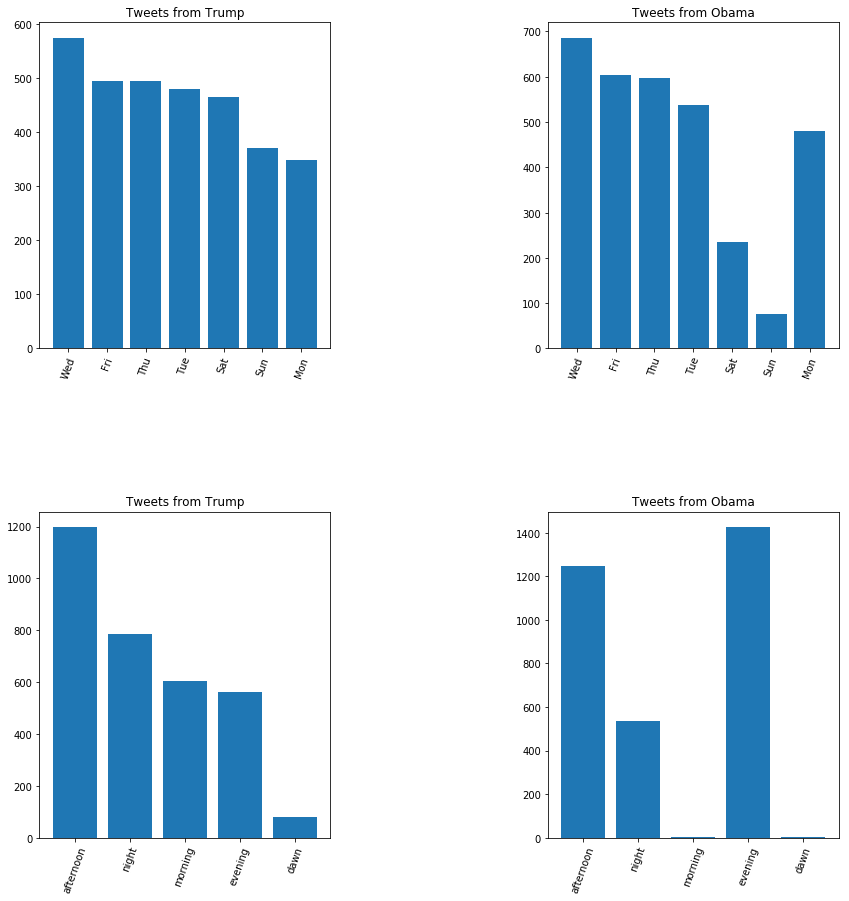

In [8]:
def extract_indeces_label_and_value(cnt, labels=None, limit=None ):
    if labels == None:
        most_common = cnt.most_common()
        most_common = most_common if limit == None else most_common[:limit]
        labels = [x for x, _ in most_common]
        values = [y for _, y in most_common]
    else:
        values = [cnt[label] for label in labels]
    
    idx = np.arange(len(labels))
    return idx, labels, values
           
for i, subject in enumerate([days, section_of_days]):
    plt.figure(1, figsize=(15, 15))

    idx, labels, _ = extract_indeces_label_and_value(subject["Trump"])
    for j, author in enumerate(twitter_accounts.keys()):
        plt.subplot(221 + j + 2 * i)
        _, _, values = extract_indeces_label_and_value(subject[author], labels=labels)
        plt.bar(idx, values)
        plt.xticks(idx, labels, rotation=70)
        plt.title("Tweets from {}".format(author))
    
plt.subplots_adjust(left=0.01, right = 0.75, wspace=0.75, hspace=0.5)
plt.show()

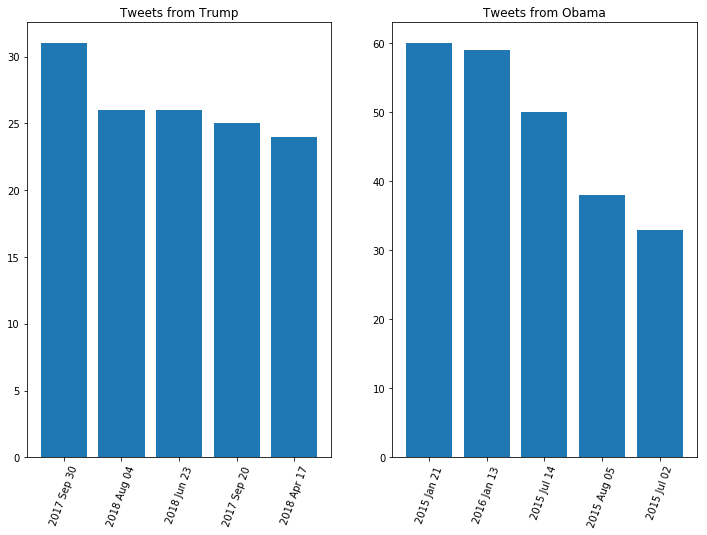

In [9]:
plt.figure(2, figsize=(12, 8))
for i, author in enumerate(twitter_accounts.keys()):
        plt.subplot(121 + i)
        idx, labels, values = extract_indeces_label_and_value(dates[author], limit=5)
        plt.bar(idx, values)
        plt.xticks(idx, labels, rotation=70)
        plt.title("Tweets from {}".format(author))

We just see on which date created the most tweets from Trump abd Obama. We can check which happened on these specific days:

+ 2018 aug 04: President Nicolás Maduro of Venezuela survives an assassination attempt by drone, live on TV
+ 2018 jun 23: 12 boys and their coach are stranded in Tham Luang Nang Non cave, Thailand by monsoon flooding, prompting an international rescue effort when they are discovered 9 days later
+ 2017 sep 20: US Federal Reserve says it will start to unwind its bond portfolio employed in wake of the financial crisis
+ 2018 apr 17: Former F.B.I. director James Comey publishes his political autobiography “A Higher Loyalty: Truth, Lies, and Leadership”

+ 2016 jan 13: Shooting in Orlando. 49 people died.
+ 2015 jul 14: Arms deal agreed between 6 world powers and Iran limiting Iranian nuclear arms but ending sanctions
+ 2015 aug 05: The Environmental Protection Agency at Gold King Mine waste water spill releases 3 million gallons of heavy metal toxin tailings and waste water into the Animas River in Colorado.
+ 2015 jul 02 BP agrees to compensate US government & gulf states 18.7 billion dollar for the 2010 Gulf of Mexico oil spill 


### Preprocess the text

Before we start to work with the text, we shall preprocess it. We should lower all of the the words, remove punctuation, and so on. Because we don't want the "python", "python?" and "Python" classified 3 different classes.

The "#" and the "@" didn't removed, because they have special meanings in the twitter syntax. For the preprocessing, the hyperlinks also can be removed.

The "&" sign is an often used symbol, but the twitter api gives it back with the "&amp", so we should replace that with "and" in the text.

In [1]:
from string import printable, punctuation

In [11]:
my_punc = punctuation.replace("@", "")
my_punc = punctuation.replace("#", "")

words_cnt_by_author = {}
words_with_hashtag = {}
words_arr_by_author = {}
ascii_tweets = {}
for author in twitter_accounts.keys():
    #we got &amp in the text field, when the user typed & symbol, so we can change it to and
    texts[author] = [tweet.replace("&amp", "and") for tweet in texts[author]]
    texts[author] = [tweet.lower() for tweet in texts[author]]
    ascii_tweets[author] = []
    for tweet in texts[author]:
        #remove weblinks
        tweet = ' '.join(word for word in tweet.split() if not word.startswith("http"))
        ascii_tweets[author].append("".join(c for c in tweet if c in printable and c not in my_punc))
    words_arr_by_author[author] = "".join(ascii_tweets[author]).split()
    words_with_hashtag[author] = Counter([word for word in words_arr_by_author[author] if word.startswith("#")])
    

Visualization also can be done on the preprocessed words.

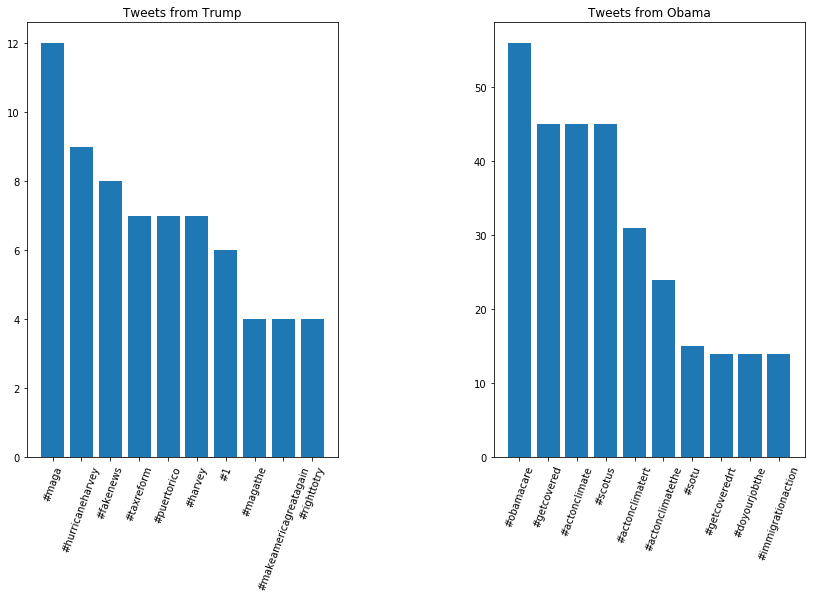

In [12]:
plt.figure(2, figsize=(12, 8))
for i, author in enumerate(twitter_accounts.keys()):
        plt.subplot(121 + i)
        idx, labels, values = extract_indeces_label_and_value(words_with_hashtag[author], limit=10)
        plt.bar(idx, values)
        plt.xticks(idx, labels, rotation=70)
        plt.title("Tweets from {}".format(author))
    
plt.subplots_adjust(left=0.1, right = 1, wspace=0.5, hspace=0.5)
plt.show()

In [13]:
from wordcloud import WordCloud, STOPWORDS

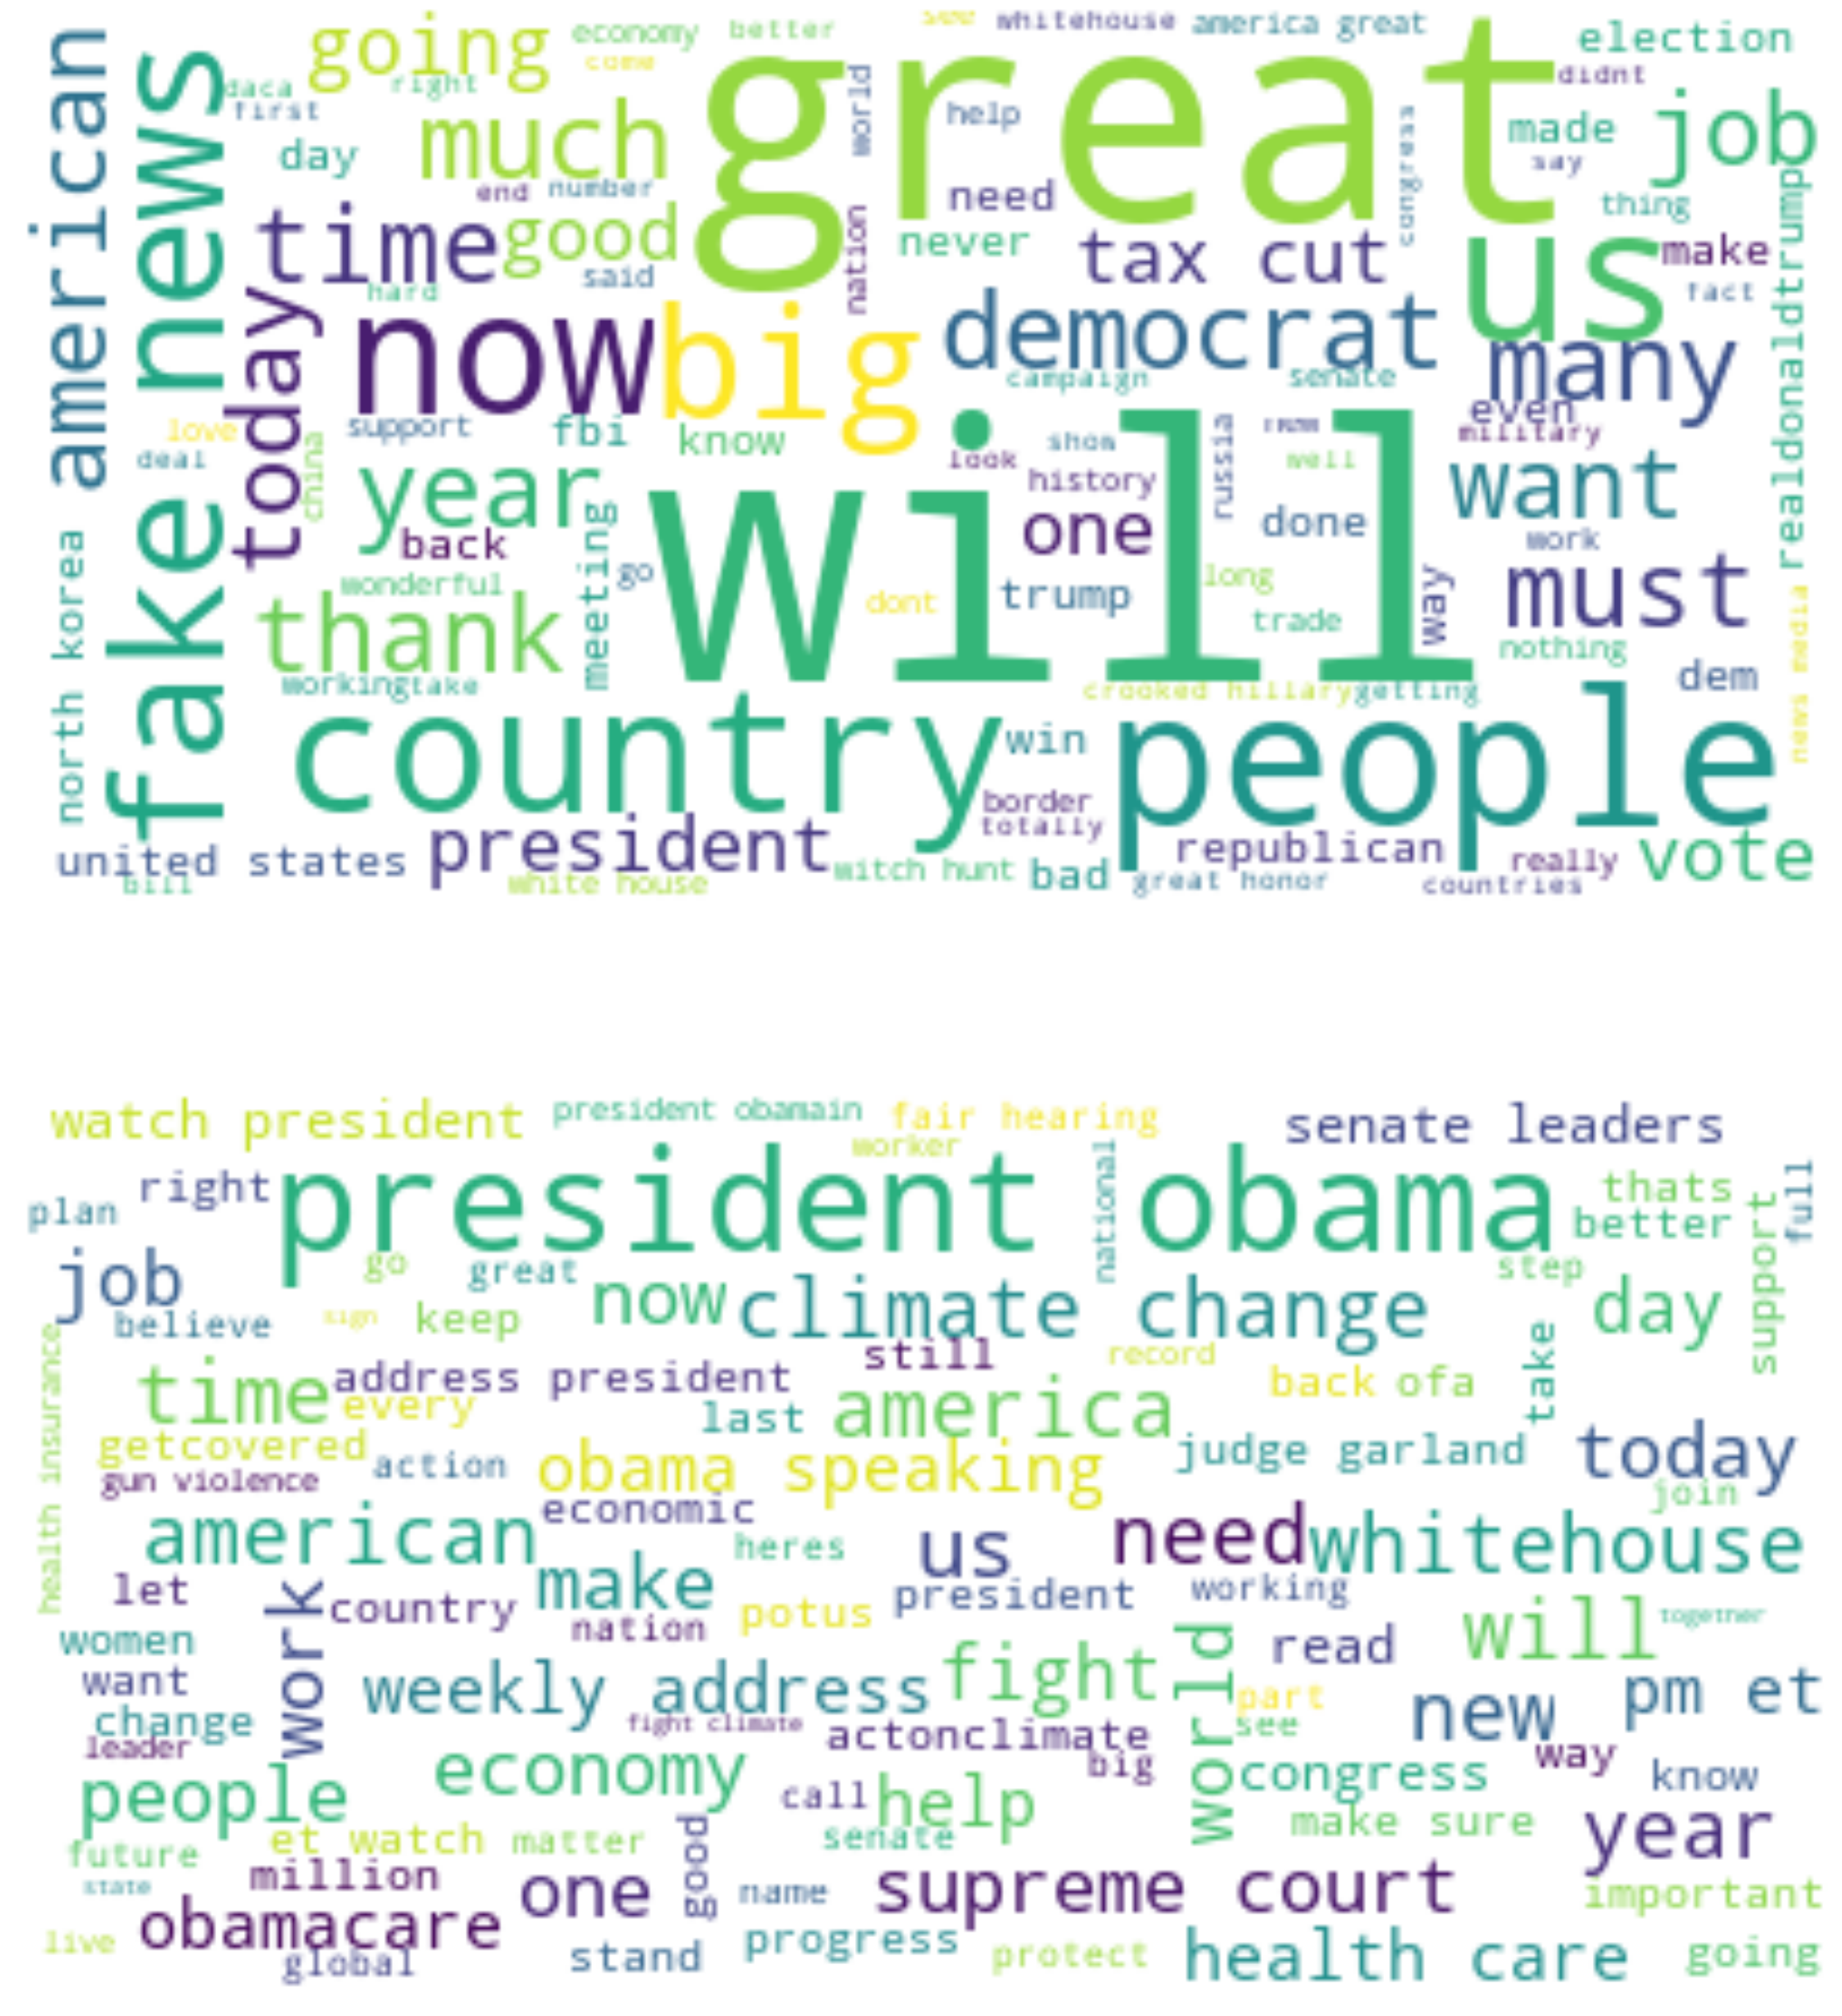

In [14]:
stop_words = set(STOPWORDS)
plt.figure(1, figsize = (50, 50))
for i, author in enumerate(twitter_accounts.keys()):
    word_cloud = WordCloud(background_color="white", max_words=100, stopwords=stop_words)
    word_cloud = word_cloud.generate(" ".join(words_arr_by_author[author]))
    plt.subplot(211 + i)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
plt.show()

## The Model

### The input vector

The input of the neural network are numerical vectors/matrices. So the textual dataset shall be convert into numerical values.
The simplest method to use one-hot-encoded vector. That's mean a big one dimensional vector will be used, and every unique word is ordered to an index of the vector. So the length of the vector is equal the number of the unique words in the dataset.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
word_2_idx = {}
idx_2_word = {}
for author in twitter_accounts.keys():
    for tweet in ascii_tweets[author]:
        for word in tweet.split():
            if word not in word_2_idx: #to prevent KeyError when there is a new word in the test dataset
                idx_2_word[len(word_2_idx)] = word
                word_2_idx[word] = len(word_2_idx)
                
VOCAB_SIZE = len(word_2_idx)
LABEL_SIZE = len(twitter_accounts)
print("There are {} unique words in the dataset".format(VOCAB_SIZE))

There are 10604 unique words in the dataset


In [16]:
def vectorize_input(tweet, word_2_idx):
    vec = torch.zeros(VOCAB_SIZE)
    for word in tweet.split():
        try:
            vec[word_2_idx[word]] = 1
        except KeyError:
            pass
    return vec

def vectorize_label(label, label_2_idx):
    return torch.LongTensor([label_2_idx[label]])

### The classifier

In pytorch, to create a new network, the most common way is that, to create a new class inherited from pytorch.nn.Module class, and in the forward function the feedforward function shall be implemented. After that, the pytorch can do the backprobagation automatically with autograd function.

For that task, a simple Multylayer perceptron will be used. A sigmoid function is added after the last layer, to force the output toward 0 or 1. In our case 1 will be means it's tweeted by  Trump and 0 means it's tweeted by Obama



In [18]:
class BinaryMLPClassifier(nn.Module):
    def __init__(self, vocab_size, num_of_layers=2, hidden_size=256):
        super(BinaryMLPClassifier, self).__init__()
        hidden_size = 1 if num_of_layers == 1 else hidden_size
        self.layers = [nn.Linear(vocab_size, hidden_size)]
        self.layers += [nn.Linear(hidden_size, hidden_size) for i in range(1, num_of_layers-1)]
        self.layers += [nn.Linear(hidden_size, 1)] if num_of_layers > 1 else []
        self.layers = nn.ModuleList(self.layers)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_):
        x = self.layers[0](input_)
        for layer in self.layers[1:]:
            x = self.sigmoid(x)
            x = layer(x)
        return self.sigmoid(x)

In [19]:
net = BinaryMLPClassifier(VOCAB_SIZE, num_of_layers=2, hidden_size=256)

In [20]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0042, -0.0018, -0.0018,  ..., -0.0042,  0.0074, -0.0044],
        [-0.0031,  0.0049, -0.0012,  ...,  0.0038,  0.0047, -0.0097],
        [ 0.0041,  0.0007,  0.0044,  ..., -0.0094,  0.0066,  0.0062],
        ...,
        [ 0.0057,  0.0013,  0.0073,  ..., -0.0088, -0.0067,  0.0081],
        [ 0.0051, -0.0049, -0.0056,  ..., -0.0095,  0.0074,  0.0026],
        [-0.0059,  0.0001,  0.0056,  ..., -0.0089, -0.0079,  0.0094]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0011, -0.0050, -0.0008, -0.0034,  0.0060,  0.0028,  0.0069,  0.0088,
         0.0045,  0.0083,  0.0071,  0.0095,  0.0070, -0.0091,  0.0010,  0.0039,
         0.0085,  0.0083,  0.0044,  0.0024,  0.0046,  0.0096,  0.0064, -0.0028,
         0.0065,  0.0040,  0.0060,  0.0003, -0.0048, -0.0023,  0.0020,  0.0028,
        -0.0089,  0.0089,  0.0021,  0.0063,  0.0049, -0.0037, -0.0053,  0.0036,
        -0.0001, -0.0063,  0.0086,  0.0061, -0.0092,  0.0062,  0.0002,  0.0073,
        -0.0088

### The dataset(s)

To evaluation a seperate train and test dataset shall be used. The current dataset is structured, in the half of the dataset belongs to Trump's tweets and the other half belongs to Obama's. So, the simplest technique, cannot be used, when we say the first 80% belongs to training dataset and the remaining belongs to the test dataset. Fortunetely pytorch has a function, which can create multiple dataset with a random split.

Another important thing is that, our dataset is well structured. So, there is a chance in that, in the first half the net will be learn that, they will produce always one of the author, and the second half will be learn to predict always the other author.
Fortunetely there is also a pytorch function which can sampling random.

But to use these function, a new class shall be created, which inherited from the pytoch.utils.data.Dataset

In [21]:
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler

In [22]:
class TwitterDataset(Dataset):
    def __init__(self, input_, word_2_idx):
        super(TwitterDataset, self).__init__()
        self.tweets = []

        for i, (author, tweets) in enumerate(input_.items()):
            label = [0.0] if author == "Trump" else [1.0]
            label = torch.Tensor(label)
            self.tweets += [[label, vectorize_input(tweet, word_2_idx)] for tweet in tweets]
        
    def __len__(self):
        return (len(self.tweets))
    
    def __getitem__(self, index):
        return self.tweets[index]

In [23]:
dataset = TwitterDataset(ascii_tweets, word_2_idx)

In [24]:
TEST_RATIO = 0.2
LEN_OF_TEST_DATASET = int(TEST_RATIO * len(dataset))
test_dataset, train_dataset = (random_split(dataset, [LEN_OF_TEST_DATASET, len(dataset) - LEN_OF_TEST_DATASET]))
random_sampler = RandomSampler(train_dataset)

In [25]:
print(len(train_dataset), len(test_dataset))

5155 1288


We can check, without training what can the net predict. The accuracy should be near 50%

In [27]:
with torch.no_grad():
    correct_cnt = 0
    for label, tweet in test_dataset:
        log_probs = net(tweet)[0][0]
        correct_cnt += 1 if log_probs.ceil() == label else 0
    print("Accuracy on the dataset: {:.2f} %".format(100 * correct_cnt / len(test_dataset)))       

C:\Users\User\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


Accuracy on the dataset: 49.69 %


In [28]:
ds_loader = DataLoader(train_dataset, batch_size=256, sampler=random_sampler)

In [30]:
net = BinaryMLPClassifier(VOCAB_SIZE, num_of_layers=2, hidden_size=256)

In the first run, the mean square error will be used for loss function with Adam optimizer. If the result not satisfying different loss functions and optimizers can be tried out.

In [31]:
num_epochs = 10
display_in_every = 2
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

for epoch in range(num_epochs):
    correct_cnt = 0
    for labels, tweets in ds_loader:
        optimizer.zero_grad()
        log_probs = net(tweets)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        i = 0
        for log_prob, label in zip(log_probs, labels): 
            correct_cnt += 1 if log_prob.round() == label else 0
    print("Train epoch: {} Loss: {:.4f}, Accuracy : {:.2f} %".format(epoch, loss.data[0], 
                                                                        100 * correct_cnt / len(train_dataset)))

C:\Users\User\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train epoch: 0 Loss: 0.1922, Accuracy : 77.75 %
Train epoch: 1 Loss: 0.1466, Accuracy : 89.70 %
Train epoch: 2 Loss: 0.0925, Accuracy : 91.25 %
Train epoch: 3 Loss: 0.0804, Accuracy : 93.39 %
Train epoch: 4 Loss: 0.0287, Accuracy : 95.67 %
Train epoch: 5 Loss: 0.0253, Accuracy : 96.99 %
Train epoch: 6 Loss: 0.0414, Accuracy : 97.81 %
Train epoch: 7 Loss: 0.0364, Accuracy : 98.31 %
Train epoch: 8 Loss: 0.0118, Accuracy : 98.74 %
Train epoch: 9 Loss: 0.0237, Accuracy : 98.89 %


The train results are very promising. It shall be checked on the test dataset.

In [32]:
with torch.no_grad():
    correct_cnt = 0
    for label, tweet in test_dataset:
        log_probs = net(tweet)[0][0]
        correct_cnt += 1 if log_probs.round() == label else 0
        
    print("Accuracy on the dataset: {:.2f} %".format(100 * correct_cnt / len(test_dataset)))       

C:\Users\User\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  after removing the cwd from sys.path.


Accuracy on the dataset: 96.12 %


The results on the test dataset are very great, too. But sanity check shall be done, to check the validity in the results.
So some random picked tweet fed to the network and check the results

In [37]:
def get_author_from_tweet(tweet):
    tweet = tweet.lower()
    tweet = ' '.join(word for word in tweet.split() if not word.startswith("http"))
    tweet = "".join(c for c in tweet if c in printable and c not in my_punc)
    input_ = vectorize_input(tweet, word_2_idx)
    output = net(input_)
    return "Trump" if output[0][0] < 0.5 else "Obama"
#Obama tweets
txts = []
txts.append(("Obama", "The first class of Obama Fellows is full of leaders like Keith—hardworking, innovative,\
                        and dedicated to partnering with their communities to drive transformational change."))
txts.append(("Obama", "Aretha helped define the American experience. In her voice, we could feel our history, \
        all of it and in every shade—our power and our pain, our darkness and our light, our quest for redemption \
        and our hard-won respect. May the Queen of Soul rest in eternal peace."))
txts.append(("Obama", "I’m confident that, together, they’ll strengthen this country we love by restoring opportunity, \
        repairing our alliances and standing in the world, and upholding our fundamental commitment to justice, \
        fairness, responsibility, and the rule of law. But first, they need our votes."))

txts.append(("Obama", "Today I’m proud to endorse such a wide and impressive array of Democratic candidates – leaders as diverse, patriotic,\
            and big-hearted as the America they’re running to represent:"))

txts.append(("Obama", "Yesterday I met with high school students on Chicago’s Southwest side who spent the summer learning to code \
        some pretty cool apps. Michelle and I are proud to support programs that invest in local youth and we’re proud \
        of these young people."))
#Trump tweets
txts.append(("Trump", "When will Republican leadership learn that they are being played like a fiddle by the Democrats on Border Security \
        and Building the Wall? Without Borders, we don’t have a country. With Open Borders, which the Democrats want, we \
        have nothing but crime! Finish the Wall!"))

txts.append(("Trump", "Five deaths have been recorded thus far with regard to hurricane Florence! Deepest sympathies and warmth go out \
        to the families and friends of the victims. May God be with them!"))

txts.append(("Trump", "When President Obama said that he has been to “57 States,” very little mention in Fake News Media. \
        Can you imagine if I said that...story of the year! "))

txts.append(("Trump",  "John Kerry had illegal meetings with the very hostile Iranian Regime, which can only serve to undercut \
        our great work to the detriment of the American people. He told them to wait out the Trump Administration! Was he \
         registered under the Foreign Agents Registration Act? BAD!"))

txts.append(("Trump", "The Wall Street Journal has it wrong, we are under no pressure to make a deal with China, they are under pressure \
to make a deal with us. Our markets are surging, theirs are collapsing. We will soon be taking in Billions in \
Tariffs & making products at home. If we meet, we meet?"))
for author, txt in txts:
    out = "The predicted author of tweet : {}, \
    the correct author of tweet: {} \nThe text if tweet:\n{}\n\n".format(get_author_from_tweet(txt), author, txt)
    out = out.replace("\t", "\s")
    print(out)
    

The predicted author of tweet : Obama,     the correct author of tweet: Obama 
The text if tweet:
The first class of Obama Fellows is full of leaders like Keith—hardworking, innovative,                        and dedicated to partnering with their communities to drive transformational change.


The predicted author of tweet : Obama,     the correct author of tweet: Obama 
The text if tweet:
Aretha helped define the American experience. In her voice, we could feel our history,         all of it and in every shade—our power and our pain, our darkness and our light, our quest for redemption         and our hard-won respect. May the Queen of Soul rest in eternal peace.


The predicted author of tweet : Obama,     the correct author of tweet: Obama 
The text if tweet:
I’m confident that, together, they’ll strengthen this country we love by restoring opportunity,         repairing our alliances and standing in the world, and upholding our fundamental commitment to justice,         fairness, 

C:\Users\User\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys
